# Análisis de Tendencias y Modelado

En esta notebook se analiza la evolución temporal de los precios de productos esenciales en supermercados de Córdoba (Disco y Hiper Libertad), con el objetivo de identificar tendencias, comportamientos estacionales o patrones significativos. A su vez, se busca aplicar modelos simples de series temporales para pronosticar precios a corto plazo.


 # 1. Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 2. Carga del dataset unificado

In [2]:
# Reutilizo el dataset limpio del EDA
df = pd.read_excel('/content/drive/MyDrive/Web Scrapping - Supermercados/datos_limpios.xlsx')

# Fecha a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Revisar estructura
df.head()


,fecha,Nombre Producto,Precio,Supermercado
0,2025-04-15,Harina,900.0,Disco
1,2025-04-15,Azucar,1160.0,Disco
2,2025-04-15,Arroz,2300.0,Disco
3,2025-04-15,Galletas dulces,2671.0,Disco
4,2025-04-15,Papa,999.0,Disco


### Determinar  ptoductos con mayor variación de precios

In [3]:
variacion_precio = df.groupby(['Nombre Producto', 'Supermercado'])['Precio'].agg(['min', 'max', 'mean', 'std']).reset_index()
variacion_precio['variacion_absoluta'] = variacion_precio['max'] - variacion_precio['min']
variacion_precio['variacion_porcentual'] = (variacion_precio['max'] - variacion_precio['min']) / variacion_precio['min'] * 100

variacion_precio.sort_values(by='variacion_absoluta', ascending=False).head(10)


,Nombre Producto,Supermercado,min,max,mean,std,variacion_absoluta,variacion_porcentual
6,Batata,Disco,599.0,1199.0,1132.333333,151.619609,600.0,100.166945
28,Manzana,Disco,1899.0,2499.0,2025.923077,180.128160,600.0,31.595577
37,Queso crema,Disco,4750.0,5300.0,4882.758621,239.521794,550.0,11.578947
42,Salame,Hiper Libertad,3082.0,3590.0,3317.414634,256.466077,508.0,16.482803
38,Queso crema,Hiper Libertad,4476.0,4795.0,4567.609756,144.593720,319.0,7.126899
33,Papa,Disco,699.0,999.0,874.000000,115.573106,300.0,42.918455
0,Aceite,Disco,4218.0,4471.0,4243.948718,77.760749,253.0,5.998103
46,Yerba,Hiper Libertad,2939.0,3190.0,3128.780488,109.127108,251.0,8.540320
12,Cerveza,Disco,3300.0,3550.0,3306.410256,40.032038,250.0,7.575758
48,Yogur,Hiper Libertad,3159.0,3375.0,3199.864865,85.765236,216.0,6.837607


❗ 👉🏻 Utilizaré el top 5 de Productos con mayor variación absoluta de precios, para este desarrollo

* Papa
* batata
* Dulce de Leche
* Manzana
* Manteca




# 3. Preparación de datos para series temporales

Analisis de cómo cambian los valores a lo largo del tiempo.

### a. Papa

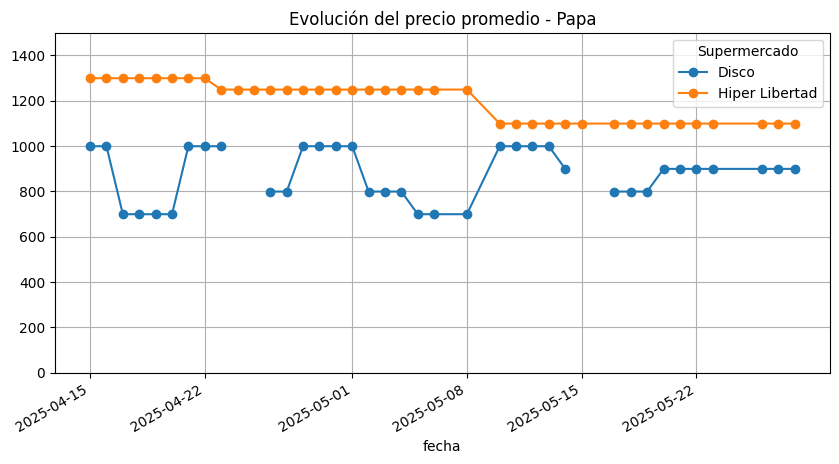

In [4]:
# Filtro por un producto
producto = 'Papa'
df_prod = df[df['Nombre Producto'] == producto]

# Agrupo por fecha y supermercado
serie = df_prod.groupby(['fecha', 'Supermercado'])['Precio'].mean().reset_index()

# Pivoteo para tener una serie por supermercado
serie_pivot_papa = serie.pivot(index='fecha', columns='Supermercado', values='Precio')
serie_pivot_papa.plot(marker='o', figsize=(10,5), title=f'Evolución del precio promedio - {producto}')
plt.grid(True)
plt.ylim(0, 1500)
plt.show()

**Disco:** El precio comienza en aproximadamente \$1000 el 15 de abril, pero el 17 de abril cae abruptamente a \$700, y se mantiene estable en ese valor hasta el 20 de abril.

**Hiper Libertad:** Muestra una tendencia completamente estable en torno a \$1300 durante todo el período. No hay variaciones.

### b. Dulce de Leche

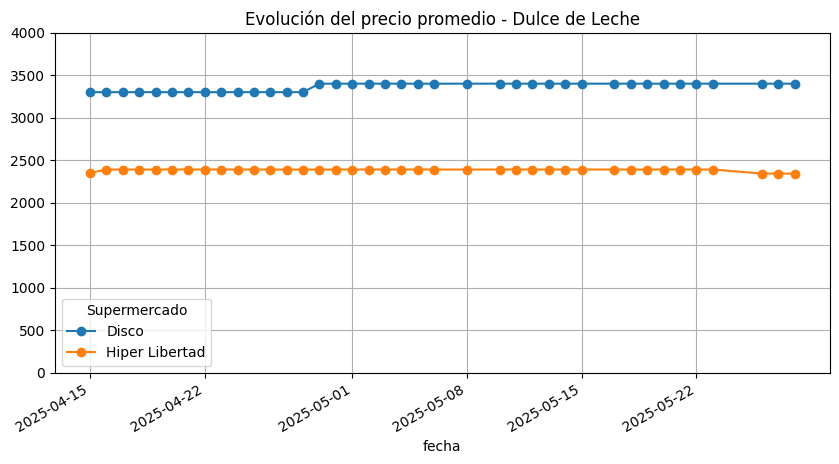

In [5]:
# Filtro por un producto
producto = 'Dulce de Leche'
df_prod = df[df['Nombre Producto'] == producto]

# Agrupo por fecha y supermercado
serie = df_prod.groupby(['fecha', 'Supermercado'])['Precio'].mean().reset_index()

# Pivoteo para tener una serie por supermercado
serie_pivot_dulce_de_leche = serie.pivot(index='fecha', columns='Supermercado', values='Precio')
serie_pivot_dulce_de_leche.plot(marker='o', figsize=(10,5), title=f'Evolución del precio promedio - {producto}')
plt.grid(True)
plt.ylim(0, 4000)
plt.show()

**Disco**: Se mantiene constante en \$3300, sin ninguna variación entre el 15 y el 20 de abril.

**Hiper Libertad**: También muestra una serie prácticamente estable, con valores cerca de \$2400, sin variaciones significativas en el periodo.

### c. Batata

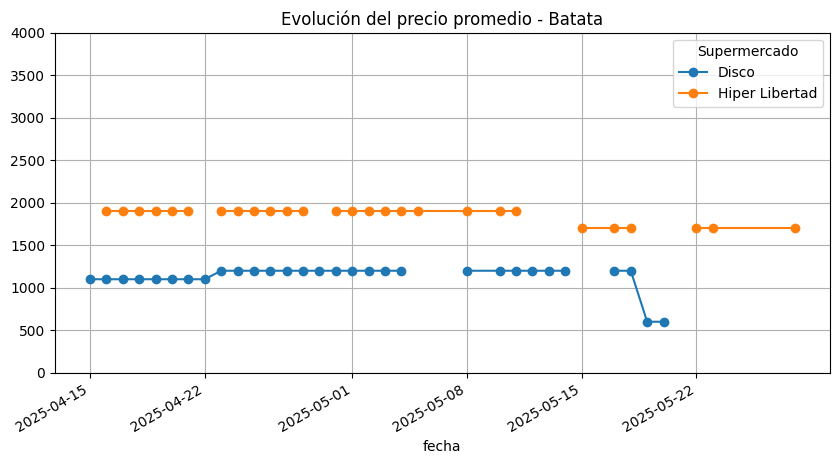

In [6]:
# Filtro por un producto
producto = 'Batata'
df_prod = df[df['Nombre Producto'] == producto]

# Agrupo por fecha y supermercado
serie = df_prod.groupby(['fecha', 'Supermercado'])['Precio'].mean().reset_index()

# Pivoteo para tener una serie por supermercado
serie_pivot_batata = serie.pivot(index='fecha', columns='Supermercado', values='Precio')
serie_pivot_batata.plot(marker='o', figsize=(10,5), title=f'Evolución del precio promedio - {producto}')
plt.grid(True)
plt.ylim(0, 4000)
plt.show()

### d. Manzana

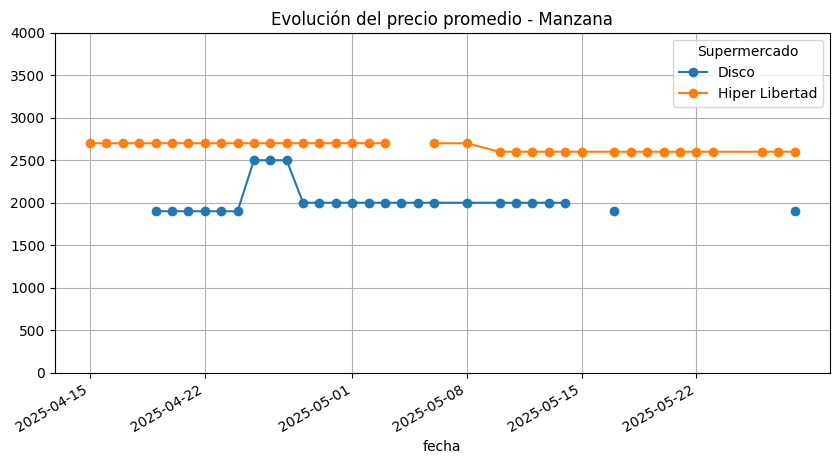

In [7]:
# Filtro por un producto
producto = 'Manzana'
df_prod = df[df['Nombre Producto'] == producto]

# Agrupo por fecha y supermercado
serie = df_prod.groupby(['fecha', 'Supermercado'])['Precio'].mean().reset_index()

# Pivoteo para tener una serie por supermercado
serie_pivot_manzana = serie.pivot(index='fecha', columns='Supermercado', values='Precio')
serie_pivot_manzana.plot(marker='o', figsize=(10,5), title=f'Evolución del precio promedio - {producto}')
plt.grid(True)
plt.ylim(0, 4000)
plt.show()

### e. Manteca

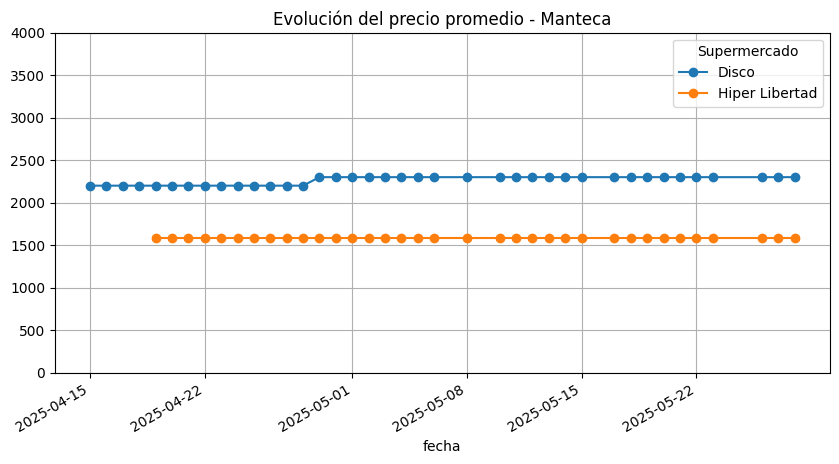

In [8]:
# Filtro por un producto
producto = 'Manteca'
df_prod = df[df['Nombre Producto'] == producto]

# Agrupo por fecha y supermercado
serie = df_prod.groupby(['fecha', 'Supermercado'])['Precio'].mean().reset_index()

# Pivoteo para tener una serie por supermercado
serie_pivot_manteca = serie.pivot(index='fecha', columns='Supermercado', values='Precio')
serie_pivot_manteca.plot(marker='o', figsize=(10,5), title=f'Evolución del precio promedio - {producto}')
plt.grid(True)
plt.ylim(0, 4000)
plt.show()

# 4. Descomposición de tendencia y estacionalidad

### a. Papa

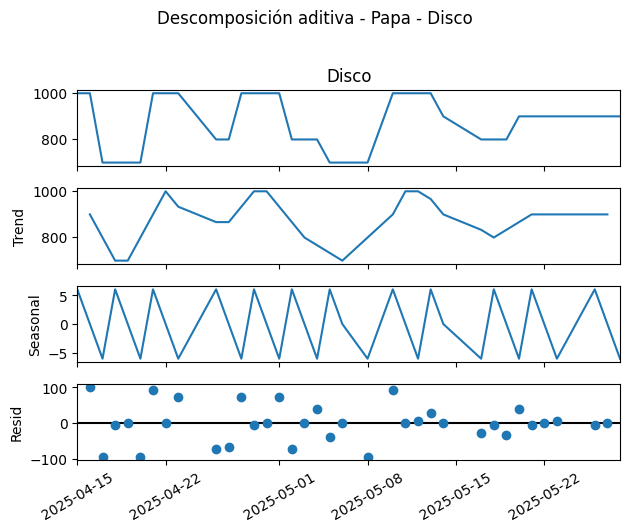

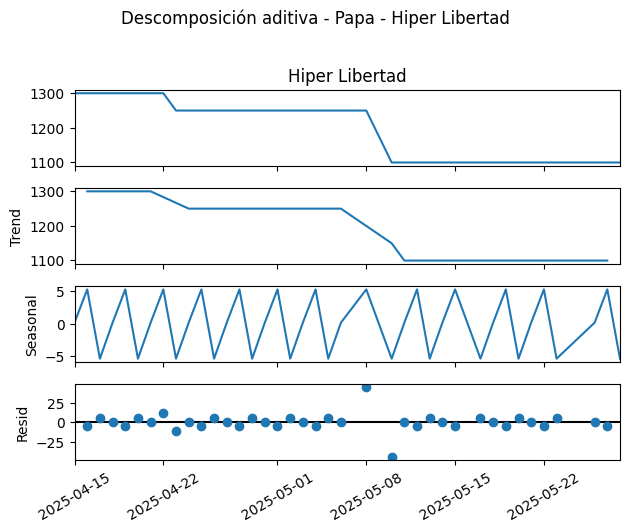

In [9]:
# Descomposición simple para Disco
serie_ts_disco_papa = serie_pivot_papa['Disco'].dropna()

decompose = seasonal_decompose(serie_ts_disco_papa, model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Papa - Disco', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

# Descomposición simple para Hiper Libertad
serie_ts_hl_papa = serie_pivot_papa['Hiper Libertad'].dropna()

decompose = seasonal_decompose(serie_ts_hl_papa , model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Papa - Hiper Libertad', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

**Descomposición aditiva - Papa - Disco**

*  Serie original:

Muestra una caída abrupta entre el 16 y 17 de abril (de \$1000 a \$700), luego permanece estable.

*  Tendencia (Trend)

Refleja una disminución sostenida, coherente con la caída de precio observada. La tendencia capta bien el cambio estructural.

*  Estacionalidad (Seasonal)

Se observan oscilaciones cíclicas leves, aunque probablemente no representen una estacionalidad real

*  Residuos (Resid)

Hay algunos residuos negativos, lo cual indica que hay pequeñas variaciones no explicadas por la suma de tendencia + estacionalidad. El valor más bajo aparece el 19 de abril.

### b. Dulce de Leche

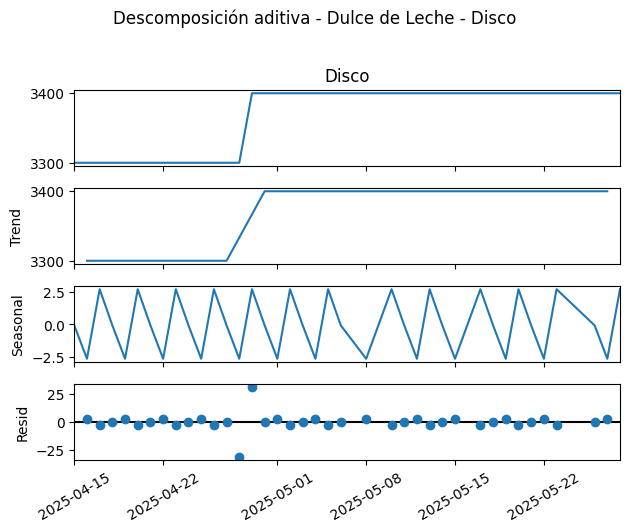

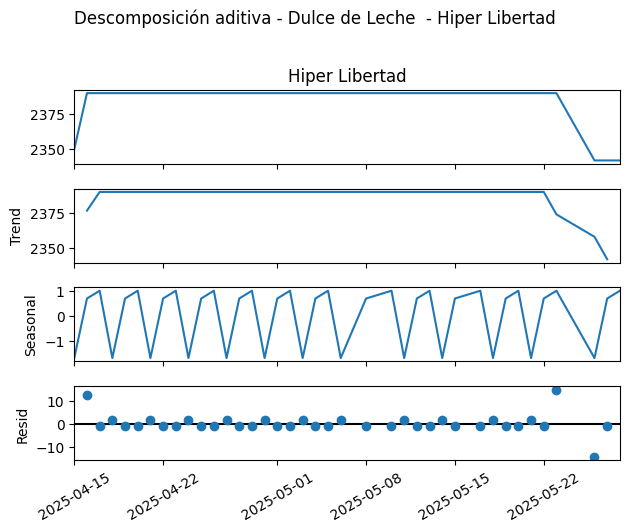

In [10]:
# Descomposición simple para Disco
serie_ts_disco_dulce = serie_pivot_dulce_de_leche['Disco'].dropna()

decompose = seasonal_decompose(serie_ts_disco_dulce , model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Dulce de Leche - Disco', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

# Descomposición simple para Hiper Libertad
serie_ts_hl_dulce = serie_pivot_dulce_de_leche['Hiper Libertad'].dropna()

decompose = seasonal_decompose(serie_ts_hl_dulce, model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Dulce de Leche  - Hiper Libertad', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

### c. Batata

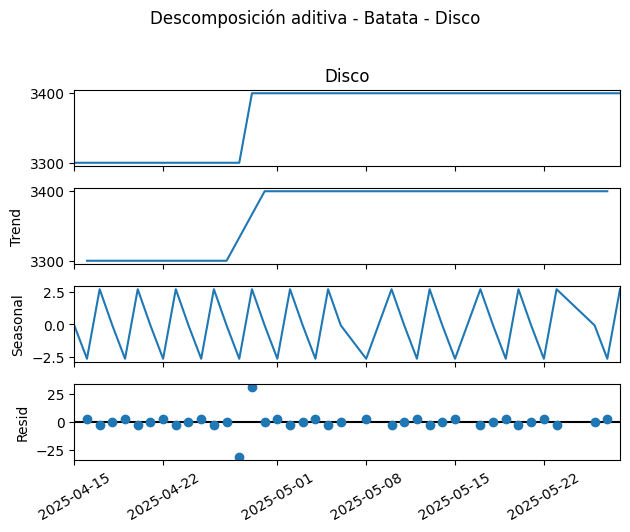

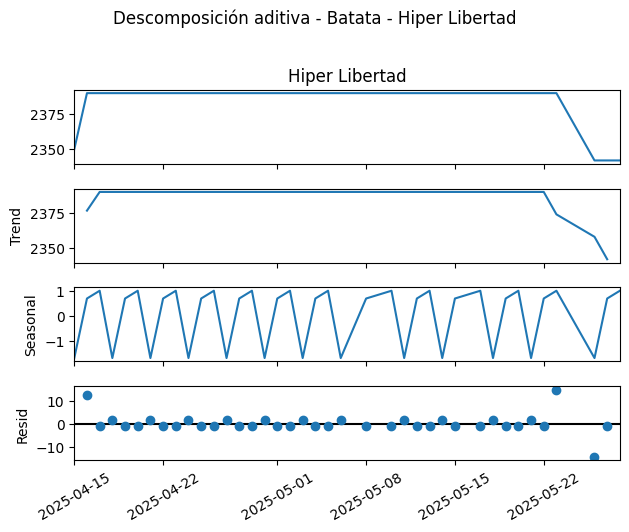

In [11]:
# Descomposición simple para Disco
serie_ts__disco_batata = serie_pivot_batata['Disco'].dropna()

decompose = seasonal_decompose(serie_ts_disco_dulce , model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Batata - Disco', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

# Descomposición simple para Hiper Libertad
serie_ts_hl_batata= serie_pivot_batata['Hiper Libertad'].dropna()

decompose = seasonal_decompose(serie_ts_hl_dulce, model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Batata - Hiper Libertad', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

### d. Manzana

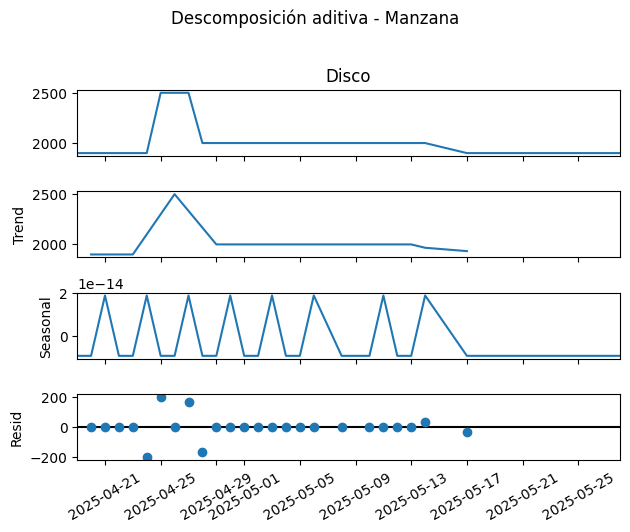

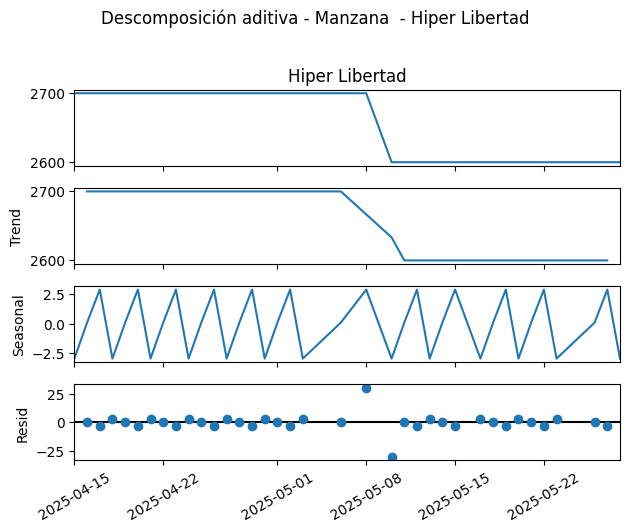

In [12]:
# Descomposición simple para Disco
serie_ts_disco_manzana = serie_pivot_manzana['Disco'].dropna()

decompose = seasonal_decompose(serie_ts_disco_manzana , model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Manzana', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

# Descomposición simple para Hiper Libertad
serie_ts_hl_manzana = serie_pivot_manzana['Hiper Libertad'].dropna()

decompose = seasonal_decompose(serie_ts_hl_manzana, model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Manzana  - Hiper Libertad', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

### e. Manteca

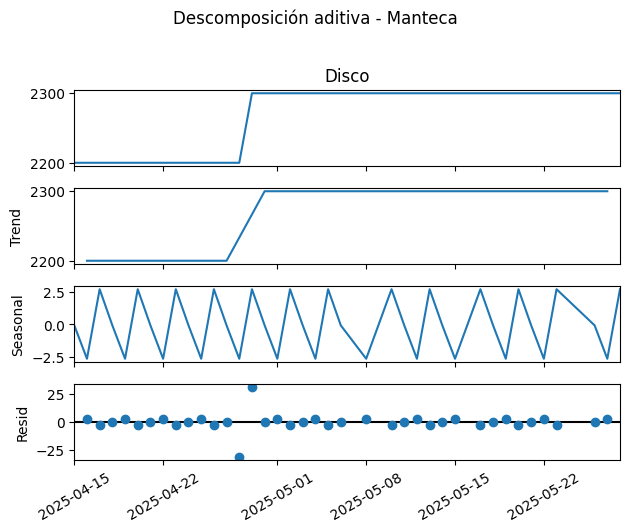

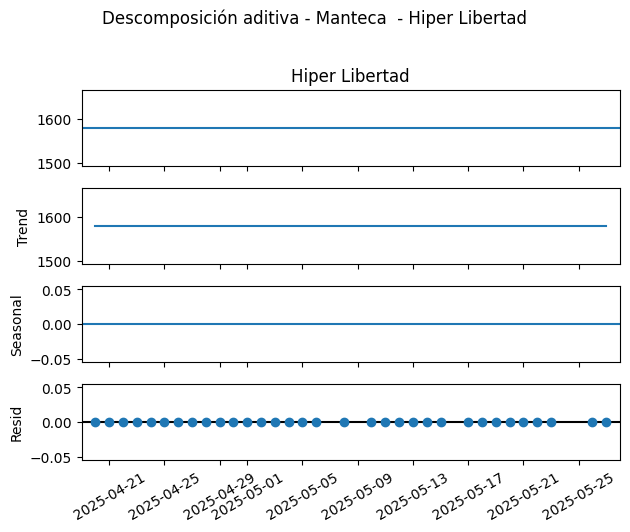

In [13]:
# Descomposición simple para Disco
serie_ts_disco_manteca = serie_pivot_manteca['Disco'].dropna()

decompose = seasonal_decompose(serie_ts_disco_manteca , model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Manteca', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

# Descomposición simple para Hiper Libertad
serie_ts_hl_manteca = serie_pivot_manteca['Hiper Libertad'].dropna()

decompose = seasonal_decompose(serie_ts_hl_manteca, model='additive', period=3)
decompose.plot()
plt.suptitle(f'Descomposición aditiva - Manteca  - Hiper Libertad', y=1.02)
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

**Descomposición aditiva - Dulce de Leche - Hiper Libertad**

* Serie original

El precio permanece estable durante todos los días, alrededor de los \$2380. No se observa variación significativa.

* Tendencia (Trend)

Es constante, al igual que la serie original. Esto indica que no hay cambios estructurales en el período analizado.

* Estacionalidad (Seasonal)

El componente estacional es nulo (línea en 0), lo que es esperable dado que no hay patrones cíclicos detectables en una serie tan corta y estable.

* Residuos (Resid)

Cero en todos los puntos. La serie es perfectamente explicada por la suma de la tendencia + estacionalidad (ambas constantes), lo que confirma que no hay ruido en la señal.

# 5. Modelado: Suavizado exponencial (Holt-Winters)

### a. Papa

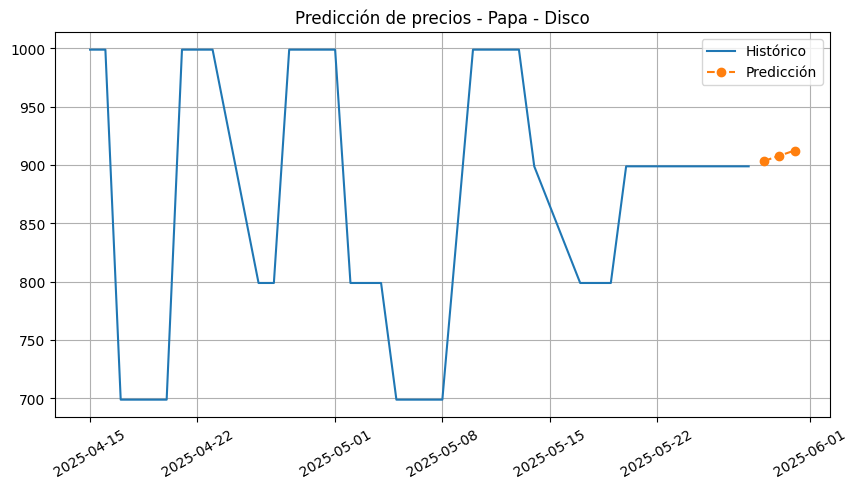

In [14]:
# Rellenar fechas faltantes
rango_fechas = pd.date_range(start=serie_ts_disco_papa.index.min(), end=serie_ts_disco_papa.index.max(), freq='D')
serie_ts_disco_papa = serie_ts_disco_papa.reindex(rango_fechas)

# Interpolar los datos faltantes:
serie_ts_disco_papa = serie_ts_disco_papa.interpolate()

# Modelo Holt-Winters para predicción simple
modelo = ExponentialSmoothing(serie_ts_disco_papa, trend='add', seasonal=None).fit()
pred = modelo.forecast(3)

# Visualización
plt.figure(figsize=(10,5))
plt.plot(serie_ts_disco_papa, label='Histórico')
plt.plot(pred, label='Predicción', linestyle='--', marker='o')
plt.title('Predicción de precios - Papa - Disco')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

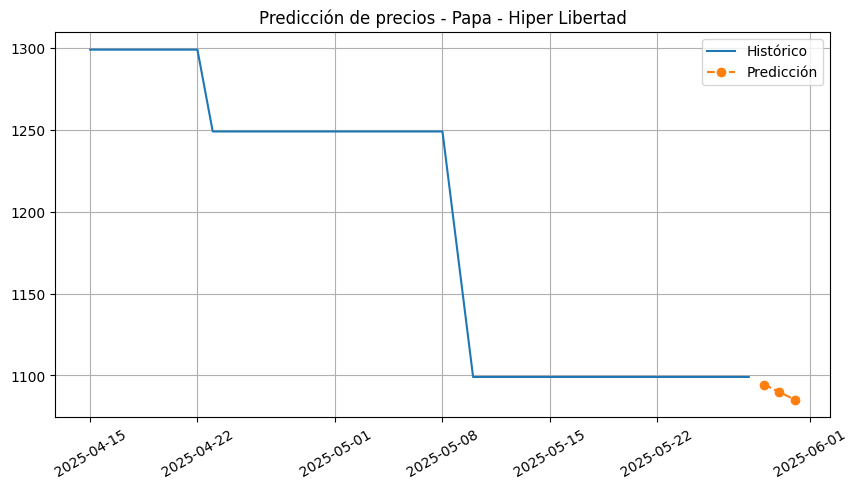

In [15]:
# Rellenar fechas faltantes
rango_fechas = pd.date_range(start=serie_ts_hl_papa.index.min(), end=serie_ts_hl_papa.index.max(), freq='D')
serie_ts_hl_papa = serie_ts_hl_papa.reindex(rango_fechas)

# Interpolar los datos faltantes:
serie_ts_hl_papa = serie_ts_hl_papa.interpolate()

# Modelo Holt-Winters para predicción simple
modelo = ExponentialSmoothing(serie_ts_hl_papa, trend='add', seasonal=None).fit()
pred = modelo.forecast(3)

# Visualización
plt.figure(figsize=(10,5))
plt.plot(serie_ts_hl_papa, label='Histórico')
plt.plot(pred, label='Predicción', linestyle='--', marker='o')
plt.title('Predicción de precios - Papa - Hiper Libertad')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

Tendencia descendente para los próximos días:

**Histórico reciente:** entre el 15 y 16 de abril el precio se mantiene en \$1.000, y luego cae bruscamente a \$700, donde permanece estable hasta el 20 de abril.

**Predicción:** a partir del 21 de abril, el modelo proyecta una caída continua, con valores aproximados de \$560, \$490 y \$420 en los siguientes días.

### b. Dulce de Leche

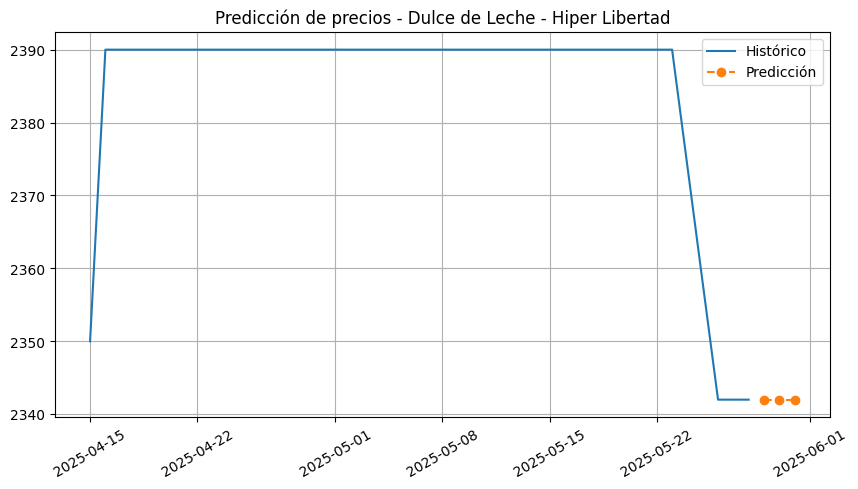

In [16]:
# Rellenar fechas faltantes
rango_fechas_dulce = pd.date_range(start=serie_ts_hl_dulce.index.min(), end=serie_ts_hl_dulce.index.max(), freq='D')
serie_ts_hl_dulce = serie_ts_hl_dulce.reindex(rango_fechas_dulce)

# Interpolar los datos faltantes:
serie_ts_hl_dulce = serie_ts_hl_dulce.interpolate()

# Modelo Holt-Winters para predicción simple
modelo = ExponentialSmoothing(serie_ts_hl_dulce, trend='add', seasonal=None).fit()
pred = modelo.forecast(3)

# Visualización
plt.figure(figsize=(10,5))
plt.plot(serie_ts_hl_dulce, label='Histórico')
plt.plot(pred, label='Predicción', linestyle='--', marker='o')
plt.title(f'Predicción de precios - Dulce de Leche - Hiper Libertad')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

Tendencia levemente bajista para el precio del dulce de leche:

**Histórico**: El precio aumenta de \$2.350  a  \$2.390 entre el 15 y 16 de abril, y luego se mantiene estable en \$2.390 hasta el 20 de abril.

**Predicción**: A partir del 21 de abril, el modelo proyecta una baja progresiva y suave, con valores estimados en torno a \$2.389, \$2.387 y  \$2.385.

### c. Batata

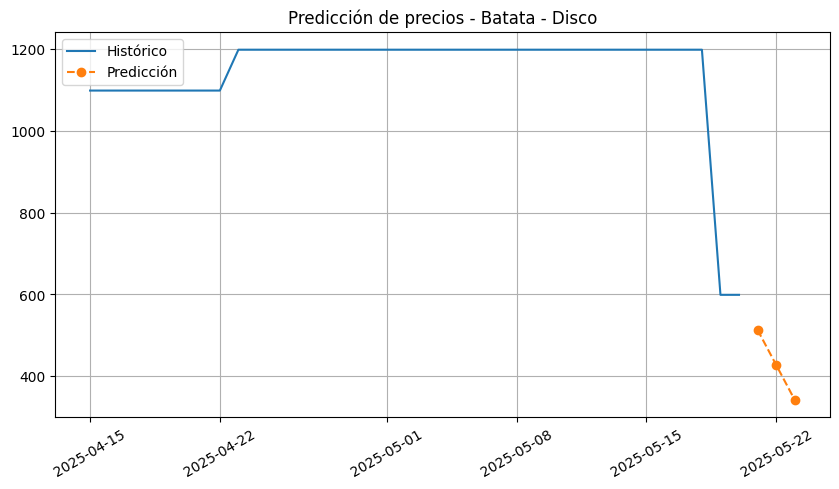

In [17]:
# Rellenar fechas faltantes
rango_fechas_batata = pd.date_range(start=serie_ts__disco_batata.index.min(), end=serie_ts__disco_batata.index.max(), freq='D')
serie_ts__disco_batata = serie_ts__disco_batata.reindex(rango_fechas_batata)

# Interpolar los datos faltantes:
serie_ts__disco_batata = serie_ts__disco_batata.interpolate()

# Modelo Holt-Winters para predicción simple
modelo = ExponentialSmoothing(serie_ts__disco_batata, trend='add', seasonal=None).fit()
pred = modelo.forecast(3)

# Visualización
plt.figure(figsize=(10,5))
plt.plot(serie_ts__disco_batata, label='Histórico')
plt.plot(pred, label='Predicción', linestyle='--', marker='o')
plt.title(f'Predicción de precios - Batata - Disco')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

### d. Manzana

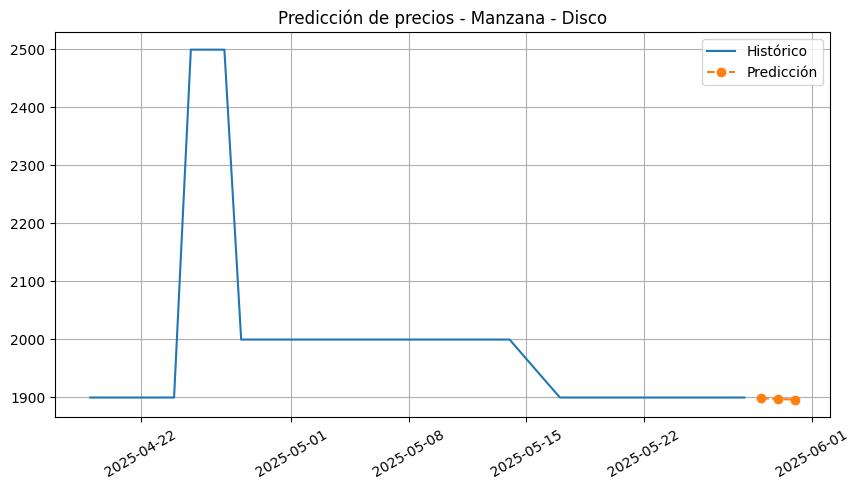

In [18]:
# Rellenar fechas faltantes
rango_fechas_manzana = pd.date_range(start=serie_ts_disco_manzana.index.min(), end=serie_ts_disco_manzana.index.max(), freq='D')
serie_ts_disco_manzana = serie_ts_disco_manzana.reindex(rango_fechas_manzana)

# Interpolar los datos faltantes:
serie_ts_disco_manzana = serie_ts_disco_manzana.interpolate()

# Modelo Holt-Winters para predicción simple
modelo = ExponentialSmoothing(serie_ts_disco_manzana, trend='add', seasonal=None).fit()
pred = modelo.forecast(3)

# Visualización
plt.figure(figsize=(10,5))
plt.plot(serie_ts_disco_manzana, label='Histórico')
plt.plot(pred, label='Predicción', linestyle='--', marker='o')
plt.title(f'Predicción de precios - Manzana - Disco')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

### e. Manteca

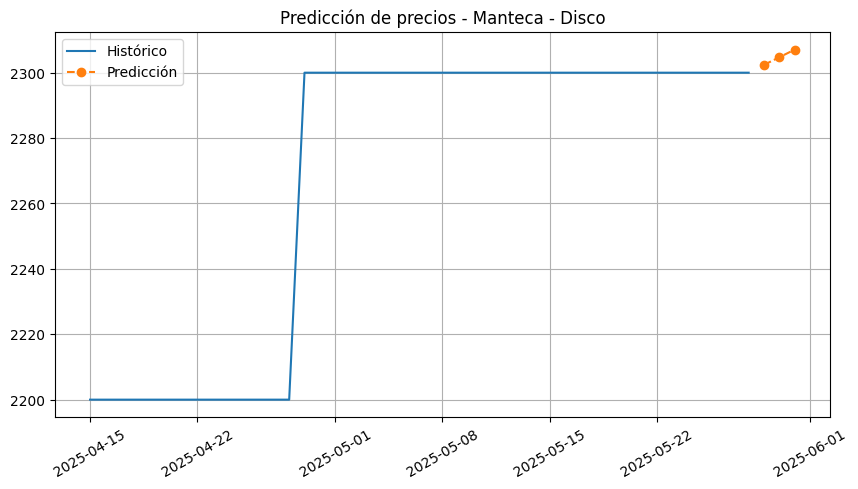

In [19]:
# Rellenar fechas faltantes
rango_fechas_manteca= pd.date_range(start=serie_ts_disco_manteca.index.min(), end=serie_ts_disco_manteca.index.max(), freq='D')
serie_ts_disco_manteca = serie_ts_disco_manteca.reindex(rango_fechas_manteca)

# Interpolar los datos faltantes:
serie_ts_disco_manteca = serie_ts_disco_manteca.interpolate()

# Modelo Holt-Winters para predicción simple
modelo = ExponentialSmoothing(serie_ts_disco_manteca, trend='add', seasonal=None).fit()
pred = modelo.forecast(3)

# Visualización
plt.figure(figsize=(10,5))
plt.plot(serie_ts_disco_manteca, label='Histórico')
plt.plot(pred, label='Predicción', linestyle='--', marker='o')
plt.title(f'Predicción de precios - Manteca - Disco')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.show()

# 6 Evaluación del modelo

# 8. Conclusiones del análisis de tendencias